<a href="https://colab.research.google.com/github/Hasim-dev/CIFAR10-Classification/blob/master/CIFAR_10_CNN_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,)) # mean ve std
                               ])

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) # mean ve std
                               ]) # transform'u oluşturduk. ToTensor ve Normalize ile tensora dönüştürdük ve normalize ettik

# /data içine data'yı koy, train_set oluştur, indir, transform'u koy
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# epoch için tek seferde 60.000 image fazla olur. "batch_size" ile bölüyoruz. "shuffle" global minimum içindi.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 84350873.33it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
# Tensor image'leri plot etmek için tekrar numpy arraye dönüştürmemiz gerekiyor.
def im_convert(tensor):
  
  # Tensor; color channel, width, channel sütunlarından oluşur. (1, 28, 28)
  image = tensor.clone().detach().numpy() 
  
  # (1, 28, 28) oldu
  image = image.transpose(1, 2, 0) 
  #print(image.shape)
  
  # Denormalization
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  
  #Normalization. Normalize ediyoruz. piksel değerleri (0, 1) arasında olmalı.
  image = image.clip(0, 1) #.clip() np ile değerleri sınırladı.
  
  return image

In [0]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

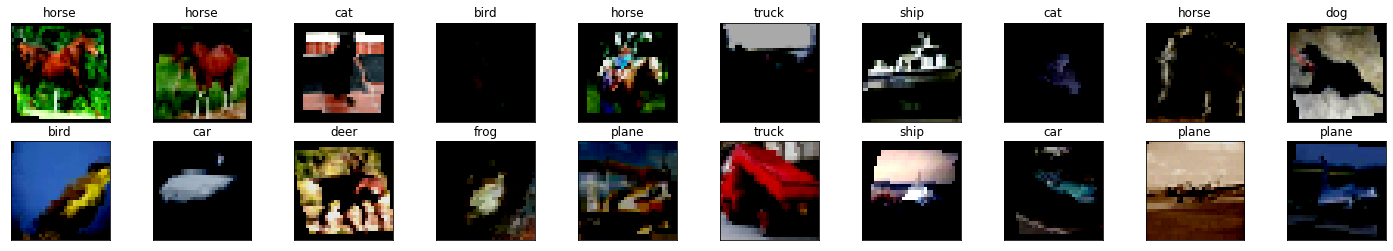

In [5]:
dataiter = iter(training_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title(classes[labels[idx].item()]) #her image için title

In [0]:
class LeNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    
    #(input kanal sayısı, feature extr. için kernel sayısı, kernel boyutu, stride uzunluğu, padding=1 seçtik ve image kenarlarını koruduk),  input conv layer defined
    #32x32 boyut, conv'dan sonra padding ile boyut korundu, poolingden sonra 16x16 oldu (2x2 kernel ile yarıya düşürdü).
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) 
    #(input kanalı öncekinin outputu kadar yani 16, output 32 seçtik)
    #16x16 boyut, conv'dan sonra padding ile boyut korundu, poolingden sonra 8x8 oldu (2x2 kernel ile yarıya düşürdü).
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) 
    #8x8 boyut, conv'dan sonra padding ile boyut korundu, poolingden sonra 4x4 oldu (2x2 kernel ile yarıya düşürdü).
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)

    #fc1 layerına 4*4*64=1024 kadar input olur. 64 katmanlı conv2 layerı ve 4x4 feature image ile gelmişti.
    self.fc1 = nn.Linear(4*4*64, 500) #nn.Linear(input sayısı, output sayısı)
    # dropout layerları genelde parametre sayıları yüksek olan layerlar arasında kullanılır
    self.dropout1 = nn.Dropout(0.5)
    # (öncekinin 500 outputu bu layerin inputu oldu, 10 output ise çıkışta)
    self.fc2 = nn.Linear(500, 10) 
    
  def forward(self, x):
    x = F.relu(self.conv1(x)) # conv1 çıkışına uygulandı. activation func. (negatif değerler "0" olur)
    x = F.max_pool2d(x, 2, 2) #pooling layer: image size yarıya düştü 16x16
    
    x = F.relu(self.conv2(x)) # conv2 çıkışına uygulandı. activation func. (negatif değerler "0" olur)
    x = F.max_pool2d(x, 2, 2) #pooling layer: image size yarıya düştü 8x8
    
    x = F.relu(self.conv3(x)) # conv2 çıkışına uygulandı. activation func. (negatif değerler "0" olur)
    x = F.max_pool2d(x, 2, 2) #pooling layer: image size yarıya düştü 4x4
    
    x = x.view(-1, 4*4*64) # (nr. cols, nr. rows) x'i istediğimiz shape'e sokuyoruz. FC layera girmeden flattened(düzlenmiş) olması gerekiyordu.
    
    x = F.relu(self.fc1(x)) # fc1 çıkışına relu uyguluyoruz.
    x = self.dropout1(x)
    x = self.fc2(x) # relu çıkışını da fc2ye veriyoruz.
    
    # Burada en son çıkışa activ. func. uygulamıyoruz.
    # Daha sonra nn.CrossEntropyLoss()'yi kullanacağız.'
    return x

In [7]:
model = LeNet()#.to(device)
model # modeli görelim.

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [9]:
epochs = 15
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_loader:
    #inputs = inputs.to(device)
    #labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels) # output ve labellar karşılaştırılıyor.
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # gelen outputlardan max değerli olanı alıyoruz.
    # ilk değer max score, ikinci değer max score'un index değerini döndürüyor.
    _, preds = torch.max(outputs, 1) 
    running_loss += loss.item()
    # single batch of images'da doğru prediction sayısını veriyor.
    running_corrects += torch.sum(preds == labels.data) 
        
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        #val_inputs = val_inputs.to(device)
        #val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1) 
        val_running_loss += val_loss.item()
        # single batch of images'da doğru prediction sayısını veriyor.
        val_running_corrects += torch.sum(val_preds == val_labels.data) 
    
    
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss) #epoch_loss, listeye eklendi.
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch', (e+1))
    print('Training Loss: {:.4f}, acc {:.4f}' .format(epoch_loss, epoch_acc.item()))
    print('Validation Loss: {:.4f}, acc {:.4f}' .format(val_epoch_loss, val_epoch_acc.item()))
    

epoch 1
Training Loss: 1.6954, acc 38.2300
Validation Loss: 1.4440, acc 47.3100
epoch 2
Training Loss: 1.4120, acc 49.0880
Validation Loss: 1.2610, acc 54.8100
epoch 3
Training Loss: 1.2946, acc 53.5480
Validation Loss: 1.1383, acc 59.3900
epoch 4
Training Loss: 1.1942, acc 57.3300
Validation Loss: 1.0945, acc 61.4800
epoch 5
Training Loss: 1.1303, acc 59.7900
Validation Loss: 1.0212, acc 63.7000
epoch 6
Training Loss: 1.0829, acc 61.8220
Validation Loss: 0.9925, acc 65.1000
epoch 7
Training Loss: 1.0423, acc 63.2340
Validation Loss: 0.9648, acc 66.2400
epoch 8
Training Loss: 1.0063, acc 64.4580
Validation Loss: 0.9089, acc 68.3600
epoch 9
Training Loss: 0.9732, acc 65.9420
Validation Loss: 0.8864, acc 68.8400
epoch 10
Training Loss: 0.9484, acc 66.7560
Validation Loss: 0.8917, acc 69.6300
epoch 11
Training Loss: 0.9328, acc 67.1980
Validation Loss: 0.8878, acc 69.1200
epoch 12
Training Loss: 0.9035, acc 68.4400
Validation Loss: 0.8712, acc 70.3700
epoch 13
Training Loss: 0.8893, acc 6

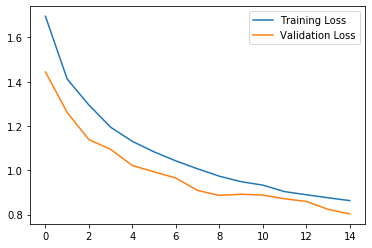

In [20]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

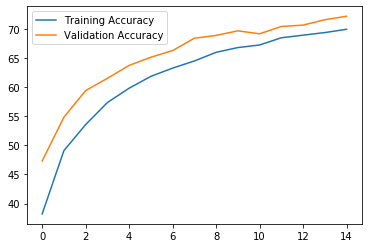

In [21]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()

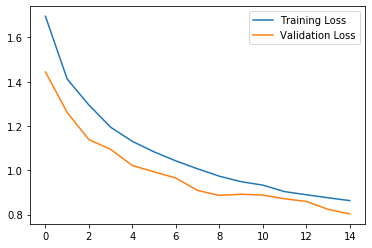

In [22]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()
plt.show()

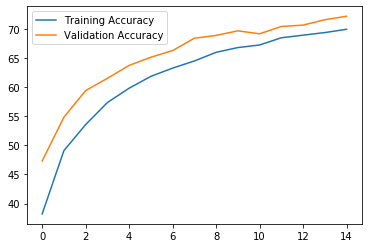

In [23]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()
plt.show()

<Response [200]>


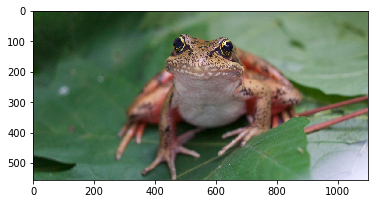

In [24]:
import requests
import PIL.ImageOps
from PIL import Image
url1 = 'https://www.burkemuseum.org/sites/default/files/images/biology/herpetology/washington/northern-red-legged-frog1-1100x555.jpg'
response = requests.get(url1, stream = True)
img1 = Image.open(response.raw)
plt.imshow(img1)
print(response)

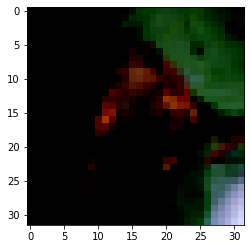

In [25]:
img1 = transform(img1)
plt.imshow(im_convert(img1))

In [26]:
img1 = img1.unsqueeze(0)
output = model(img1)
_, pred = torch.max(output, 1) 
print(classes[pred.item()])

bird


deer


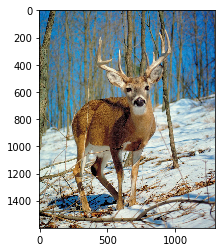

In [35]:
url2 = 'https://cdn.britannica.com/40/109040-050-62EEDEA6/Male-white-tailed-deer.jpg'
response = requests.get(url2, stream = True)
img2 = Image.open(response.raw)
plt.imshow(img2)
img2 = transform(img2)
img2 = img2.unsqueeze(0)
output = model(img2)
_, pred = torch.max(output, 1) 
print(classes[pred.item()])

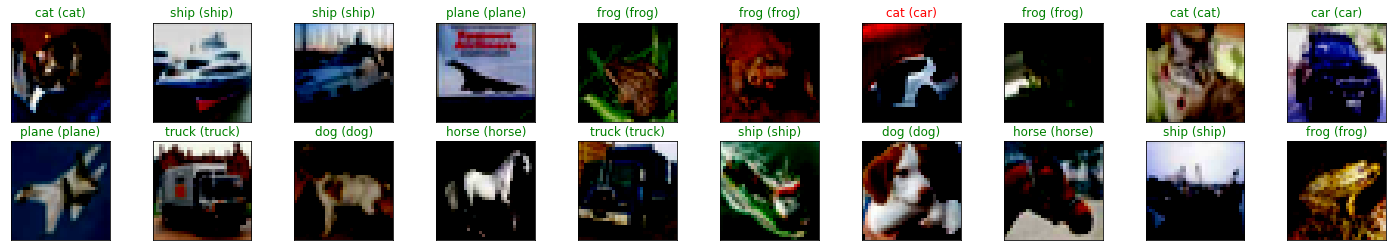

In [33]:
dataiter = iter(validation_loader) # training loader(bir iterable) üzerinden iterate edecek.
images, labels = dataiter.next() # access it one at a time with next(), returns image, label
images = images#.to(device)
labels = labels#.to(device)
output = model(images)
_, preds = torch.max(output, 1) 

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # rows, columns, index
  plt.imshow(im_convert(images[idx])) # images[idx] tensor döndürür, np array için "im_convert"e sokuyoruz.
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red")) #her image için title